In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string

from sklearn.model_selection import (StratifiedKFold, train_test_split, 
                                     GridSearchCV, cross_val_score)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report)

In [9]:
d_train = pd.read_csv("../input/nlp-getting-started/train.csv")
d_train.drop(d_train[['keyword','location']], axis=1, inplace=True)

d_train.tail()

,id,text,target
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1
7612,10873,The Latest: More Homes Razed by Northern Calif...,1


In [10]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [11]:
d_train.isnull().sum()

id        0
text      0
target    0
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


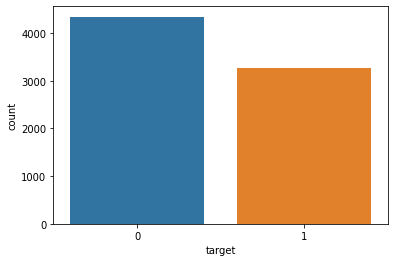

In [12]:
sns.countplot(d_train.target)
plt.show()

### Preprocessing data (NLP)

In [13]:
# Remove special characters and others
import re

## remove URL
def remove_URL(text):
    new_text = " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    return new_text

## Making text to lower case
def lower_case(text):
    return text.lower()

def butiful(text):
    text = BeautifulSoup(text).get_text()
    return text

## Removing Numbers
def remove_num(text):
    new_text = re.sub(r'\d+',"",text)
    return new_text

## Removing Punctuation
def remove_punc(text):
    trans = str.maketrans("","",string.punctuation)
    return text.translate(trans)

Tokenize (tokenizing means spliting string into words)

Lemmatize (Lemmatizeing given bu eg: if we have a word (learn,learning) learning can be lemmatized to learn.)

Removing stop words (stop wordsa are joining words used to join the text like(is,was,and,or etc.))

In [21]:
# Tokenizer
def tokenizer(text):
    text = word_tokenize(text)
    return text

# Stopwords
def remove_stopword(text):
    text = [i for i in text if not i in stopwords.words('english')]
    return text

# Lemmatize
lemmatize = WordNetLemmatizer()
def Lemmatize(text):
    text = [lemmatize.lemmatize(token) for token in text]
    return text

In [22]:
def preprocess(text):
    text = remove_URL(text)
    text = butiful(text)
    text = lower_case(text)
    text = remove_num(text)
    text = remove_punc(text)
    text = tokenizer(text)
    text = remove_stopword(text)
    text = Lemmatize(text)
    text = " ".join(text)
    return text

# data training
training_set = []
for i in d_train.text:
    text_data = preprocess(i)
    training_set.append(text_data)
    
d_train['preprocessing_results'] = training_set

In [34]:
d_test = pd.read_csv("../input/nlp-getting-started/test.csv")
d_test.drop(d_test[['keyword','location']], axis=1, inplace=True)

# data testing
testing_set = []
for i in d_test.text:
    text_data = preprocess(i)
    testing_set.append(text_data)
    
d_test['preprocessing_results'] = testing_set

In [24]:
d_train.head()

,id,text,target,preprocessing_results
0,1,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [66]:
d_test.head()

,id,text,preprocessing_results
0,0,Just happened a terrible car crash,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


### Vectorize the text data

In [35]:
count_vect = CountVectorizer()
train_vec = count_vect.fit_transform(d_train['preprocessing_results'])
test_vec = count_vect.transform(d_test['preprocessing_results'])

print(train_vec.shape)
print(test_vec.shape)

(7613, 12840)
(3263, 12840)


### Model

In [58]:
x_train, x_test, y_train, y_test = train_test_split(train_vec, d_train.target,
                                                    test_size=0.2,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6090, 12840)
(1523, 12840)
(6090,)
(1523,)


In [61]:
'''
# Hyperparameter tunning and Cross-Validation
def hyperparameter(x_train, y_train):
    params_grid = dict(n_estimators = list(range(100,600,100)),
                       max_depth = list(range(100,1000,100)))

    model = RandomForestClassifier()
    cv = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(model, param_grid=params_grid,
                                   cv=cv, n_jobs=-1, verbose=5)

    grid_search.fit(x_train, y_train)
    #result = pd.DataFrame(grid_search_SVC.cv_results_)
    print('Best score: {:.2f}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

start = time.perf_counter()
hyperparameter(x_train, y_train)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)
'''

"\n# Hyperparameter tunning and Cross-Validation\ndef hyperparameter(x_train, y_train):\n    params_grid = dict(n_estimators = list(range(100,600,100)),\n                       max_depth = list(range(100,1000,100)))\n\n    model = RandomForestClassifier()\n    cv = StratifiedKFold(n_splits=10)\n    grid_search = GridSearchCV(model, param_grid=params_grid,\n                                   cv=cv, n_jobs=-1, verbose=5)\n\n    grid_search.fit(x_train, y_train)\n    #result = pd.DataFrame(grid_search_SVC.cv_results_)\n    print('Best score: {:.2f}'.format(grid_search.best_score_))\n    print('Best parameters: {}'.format(grid_search.best_params_))\n\nstart = time.perf_counter()\nhyperparameter(x_train, y_train)\nelapsed = time.perf_counter() - start\nprint('Elapsed %.3f seconds.' % elapsed)\n"

In [62]:
start = time.perf_counter()

# Model
rf = RandomForestClassifier(max_depth = 400, n_estimators = 300,random_state=0)
rf.fit(x_train, y_train) # fit in model
y_pred = rf.predict(x_test) # predict data 

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Elapsed 54.056 seconds.


In [63]:
print('Accuracy_test : {:.4f}'.format(accuracy_score(y_test, y_pred)), 
      'Precision_test : {:.4f}'.format(precision_score(y_test, y_pred, average='macro')), 
      'Recall_test : {:.4f}'.format(recall_score(y_test, y_pred, average='macro')), 
      'F1-Score : {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

# Classification report
print('\nclassification report testing : \n', classification_report(y_test, y_pred))
print('Elapsed %.3f seconds.' % elapsed)

Accuracy_test : 0.8037 Precision_test : 0.8182 Recall_test : 0.7803 F1-Score : 0.7882

classification report testing : 
               precision    recall  f1-score   support

           0       0.78      0.92      0.85       886
           1       0.86      0.64      0.73       637

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Elapsed 54.056 seconds.


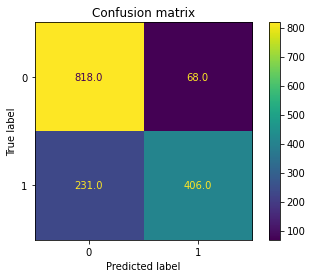

In [64]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(rf, x_test, y_test, 
                             values_format='.1f')

disp.ax_.set_title("Confusion matrix")
plt.show()

In [72]:
# Predict
prediction = rf.predict(test_vec)

# Save
submission = pd.DataFrame({
    'id':d_test['id'], 
    'target':prediction
})

submission.to_csv('Submission.csv',index = False)